# 1. Import Lib

In [1]:
import networkx as nx
import numpy as np
from sthype import SpatialGraph, SpatialTemporalGraph
from sthype.graph_functions import spatial_temporal_graph_from_spatial_graphs
from sthype.plot import plot_spatial_temporal_graph, plot_spatial_temporal_graph_node, plot_spatial_graph, plot_spatial_temporal_graph_hyperedge
import matplotlib.pyplot as plt
import os
import pickle
import pandas as pd
from shapely import LineString

%load_ext autoreload
%autoreload 2

# 2. Import SpatialGraph

In [2]:
max_timesteps = 50
directory = "/home/ipausers/hamzaoui/Documents/Data/Prince/20220508_Plate02"

timesteps = []
for file in os.listdir(directory):
    timesteps.append(file)
timesteps.sort()

spatial_graphs = []
for timestep in timesteps[:max_timesteps]:
    print('Processing timestep :', timestep)
    G, pos = pickle.load(open(f"{directory}/{timestep}/Analysis/nx_graph_pruned_width.p", 'rb'))
    for u, v, edge_data in G.edges(data=True):
        edge_data['pixels'] = edge_data.pop('pixel_list')
    for u, node_data in G.nodes(data=True):
        node_data['position'] = pos[u]
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    Sg = SpatialGraph(G0)
    spatial_graphs.append(Sg)

spatial_graph = spatial_graphs[-1]
sg = spatial_graph
print('Amount of Spatial Graphs:', len(spatial_graphs))

Processing timestep : 20220504_1900_Plate02
Processing timestep : 20220504_2100_Plate02
Processing timestep : 20220504_2300_Plate02
Processing timestep : 20220505_0100_Plate02
Processing timestep : 20220505_0300_Plate02
Processing timestep : 20220505_0500_Plate02
Processing timestep : 20220505_0700_Plate02
Processing timestep : 20220505_0900_Plate02
Processing timestep : 20220505_1100_Plate02
Processing timestep : 20220505_1300_Plate02
Processing timestep : 20220505_1500_Plate02
Processing timestep : 20220505_1700_Plate02
Processing timestep : 20220505_1900_Plate02
Processing timestep : 20220505_2100_Plate02
Processing timestep : 20220505_2300_Plate02
Processing timestep : 20220506_0100_Plate02
Processing timestep : 20220506_0300_Plate02
Processing timestep : 20220506_0500_Plate02
Processing timestep : 20220506_0700_Plate02
Processing timestep : 20220506_0900_Plate02
Processing timestep : 20220506_1100_Plate02
Processing timestep : 20220506_1300_Plate02
Processing timestep : 20220506_1

# 3. Create Stg

In [3]:
spatial_temporal_graph = spatial_temporal_graph_from_spatial_graphs(spatial_graphs, np.arange(len(spatial_graphs)), verbose=1)
stg = spatial_temporal_graph

Segmentation
Edge Activation
Comparing with graph 49
Comparing with graph 48
Comparing with graph 47
Comparing with graph 46
Comparing with graph 45
Comparing with graph 44
Comparing with graph 43
Comparing with graph 42
Comparing with graph 41
Comparing with graph 40
Comparing with graph 39
Comparing with graph 38
Comparing with graph 37
Comparing with graph 36
Comparing with graph 35
Comparing with graph 34
Comparing with graph 33
Comparing with graph 32
Comparing with graph 31
Comparing with graph 30
Comparing with graph 29
Comparing with graph 28
Comparing with graph 27
Comparing with graph 26
Comparing with graph 25
Comparing with graph 24
Comparing with graph 23
Comparing with graph 22
Comparing with graph 21
Comparing with graph 20
Comparing with graph 19
Comparing with graph 18
Comparing with graph 17
Comparing with graph 16
Comparing with graph 15
Comparing with graph 14
Comparing with graph 13
Comparing with graph 12
Comparing with graph 11
Comparing with graph 10
Comparing w

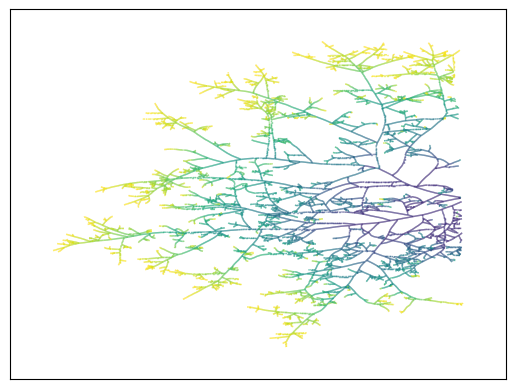

In [4]:
plot_spatial_temporal_graph(spatial_temporal_graph, color_group='activation')

# 4. Growth Speed Compared To Tip Radius

## Init

In [5]:
g_t = []
for i in range(max_timesteps):
    g_t.append(stg.get_graph_at(i))
widths_t = []

hyperedge_e = {}
for u, v, ed in g_t[-1].edges(data=True):
    hyperedge_e.setdefault(ed["hyperedge"], []).append((u, v, ed['activation'], 1.725*LineString(ed['pixels']).length))

In [6]:
i=0
tips = []
tips_light = []
growth_l = []
growth_s = []
growth_v = []
for edges in hyperedge_e.values():
    length = np.sum([l for u,v,a,l in edges])
    if length < 1000:
        i+=1
        continue
    for i in range(1, max_timesteps-1):
        widths = [g_t[i+1][u][v]['attributes'].get('width', [np.nan]) for u, v, a, l in edges if a==i]
        widths = [w for ws in widths for w in ws]
        width = 1.725*np.median(widths)
        if np.isnan(width) or width<=1.5:
            continue
        lengths = [l for u, v, a, l in edges if a==i+1]
        ss = [1.725*np.pi*l*np.median(g_t[a][u][v]['attributes'].get('width', np.nan)) for u, v, a, l in edges if a==i+1]
        vs = [1.725*1.725*np.pi*l*np.median(g_t[a][u][v]['attributes'].get('width', np.nan))*np.median(g_t[a][u][v]['attributes'].get('width', np.nan))/4 for u, v, a, l in edges if a==i+1]
        length = np.sum(lengths)
        if length==0 or length>1000:
            continue
        tips.append(width)
        growth_l.append(length)
        if np.isnan(ss).any():
            continue
        tips_light.append(width)
        s = np.sum(ss)
        v = np.sum(vs)
        growth_s.append(s)
        growth_v.append(v)

radius = np.array(tips)/2
radius_light = np.array(tips_light)/2
growth_l = np.array(growth_l)/2
growth_s = np.array(growth_s)/2
growth_v = np.array(growth_v)/2
print("ignored edges :", i)

/home/ipausers/hamzaoui/.conda/envs/STHypeEnv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ipausers/hamzaoui/.conda/envs/STHypeEnv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ignored edges : 52


## To Df

In [7]:
df = pd.DataFrame()
df['radius (um)'] = radius
df['length_growth_speed (um/h)'] = growth_l

df2 = pd.DataFrame()
df2['radius (um)'] = radius_light
df2['surface_growth_speed (um²/h) (2pi*r*l)'] = growth_s
df2['volume_growth_speed (um³/h) (pi*r²*l)'] = growth_v

In [8]:
df.to_csv('/home/ipausers/hamzaoui/Documents/Data/Plot/Growth speed vs tip/20220508_Plate02_length_growth_speed.csv')
df2.to_csv('/home/ipausers/hamzaoui/Documents/Data/Plot/Growth speed vs tip/20220508_Plate02_surface_and_volume_growth_speed.csv')

## Analysis

0.6354282759497876

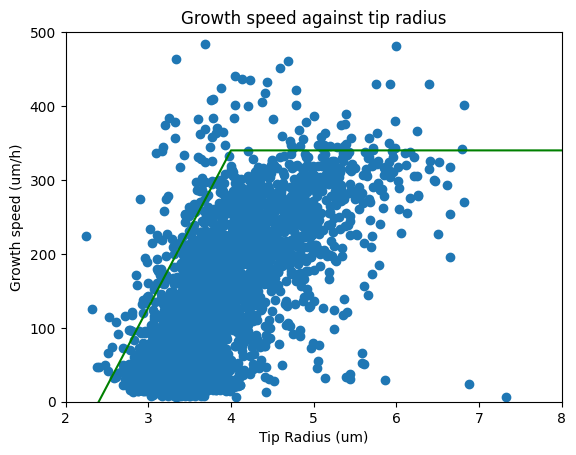

In [9]:
plt.scatter(radius, growth_l)

r0 = 2.4
rmax= 4.

r = np.linspace(2, 8, 100)
y = 340*np.minimum(1, (r-r0)/(rmax-r0))
plt.plot(r, y, color='green')

plt.title('Growth speed against tip radius')
plt.xlabel('Tip Radius (um)')
plt.ylabel('Growth speed (um/h)')
plt.xlim(2, 8)
plt.ylim(0, 500)
np.corrcoef(radius, growth_l)[0, 1]